This notebook looks at data provided by the University of Guelph on horse colic cases. 

A HistGradientBoostingClassifier model is developed because this allows for missing data -- simply removing all of the missing data results in a very small dataset to train and test with. 


In [420]:
# First, read in data and clean it
import pandas as pd
import numpy as np

# Headers from the horse-colic.names.txt file
data_headers = ['had_surgery','age','hospital_number','rectal_temp','pulse',
    'resp_rate','temp_of_extremities','peripheral_pulse','mucous_membrane',
    'capillary_refill_time','pain','peristalsis','abdominal_distension',
    'nasogastric_tube','nasogastric_reflux','nasogastric_reflux_PH',
    'rectal_examination_feces','abdomen','packed_cell_volume','total_protein',
    'abdominocentesis_appearance','abdomcentesis_total_protein','outcome',
    'had_surgical_lesion','lesion_site','lesion_type','lesion_subtype',
    'lesion_specific_code','cp_data']

# Load the dataset
data = pd.read_csv('uci-horse-colic-data/horse-colic.data.csv',sep=' ',names=data_headers)
test_data = pd.read_csv('uci-horse-colic-data/horse-colic.test.csv',sep=' ',names=data_headers)

# The cp_data column contains no data, can delete this.
data = data.drop('cp_data', axis=1)
test_data = test_data.drop('cp_data', axis=1)

# The data contains ? in place of missing/NaN data. Change this.
data[data == '?'] = np.nan
data.astype(dtype=float)

test_data[test_data == '?'] = np.nan
test_data.astype(dtype=float)

# Remove data missing outcome
missing_outcome = data[data.outcome.isnull()]
data = data.drop(missing_outcome.index)

missing_outcome = test_data[test_data.outcome.isnull()]
test_data = test_data.drop(missing_outcome.index)

# Null or missing data
#print(data.isnull().sum())
num_missing_data = data.isnull().any(axis=1).sum()
print('\nTotal empty data points: ', num_missing_data)

num_missing_test_data = test_data.isnull().any(axis=1).sum()
print('Total empty test data points: ', num_missing_test_data)

print('Dataset size: ', data.shape)
print('Test dataset size: ', test_data.shape)



Total empty data points:  293
Total empty test data points:  66
Dataset size:  (299, 28)
Test dataset size:  (67, 28)


In [421]:
import pandas as pd
# Make some changes to the dataframe

# Convert outcome to words
def outcome_str(y):
    outcomes = []
    for val in y:
        if val == '1':
            outcome = 'lived'
        elif val == '2':
            outcome = 'died'
        elif val == '3':
            outcome = 'euthanized'
        outcomes += [outcome]
    return outcomes

# Add new column with outcome in words
data.insert(0, 'outcome_in_words', outcome_str(data['outcome']),True)
test_data.insert(0, 'outcome_in_words', outcome_str(test_data['outcome']),True)

# Makes more sense for 'had_surgery' to be either 0 or 1
data['had_surgery'] = data['had_surgery'].replace('2','0')
test_data['had_surgery'] = test_data['had_surgery'].replace('2','0')

# The age column has incorrect numbers (9 should be 2)
data['age'] = data['age'].replace(9,2)
test_data['age'] = test_data['age'].replace(9,2)

data.head()

,outcome_in_words,had_surgery,age,hospital_number,rectal_temp,pulse,resp_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,had_surgical_lesion,lesion_site,lesion_type,lesion_subtype,lesion_specific_code
0,died,0,1,530101,38.50,66,28,3,3,NaN,...,45.00,8.40,NaN,NaN,2,2,11300,0,0,2
1,euthanized,1,1,534817,39.2,88,20,NaN,NaN,4,...,50,85,2,2,3,2,2208,0,0,2
2,lived,0,1,530334,38.30,40,24,1,1,3,...,33.00,6.70,NaN,NaN,1,2,0,0,0,1
3,died,1,2,5290409,39.10,164,84,4,1,6,...,48.00,7.20,3,5.30,2,1,2208,0,0,1
4,died,0,1,530255,37.30,104,35,NaN,NaN,6,...,74.00,7.40,NaN,NaN,2,2,4300,0,0,2


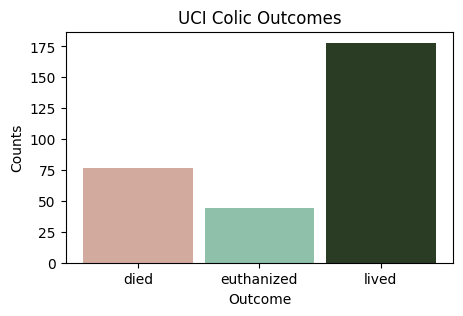

In [422]:
import matplotlib.pyplot as plt

# Create a color scheme to use for the plots in this notebook
colors = ['#D3AB9E','#764248','#8FC0A9','#094D92','#2A3C24']

# Plot histogram showing outcomes
fig, ax = plt.subplots(figsize=(5,3))
n_bars = data.outcome_in_words.nunique()
ax_bars = np.linspace(0,n_bars-1,n_bars).astype(int)
N, bins, patches = plt.hist(
    data.outcome_in_words, bins=[x for i in ax_bars for x in (i-0.45,i+0.45)])
for i in range(len(N)):
    patches[i].set_facecolor(colors[i])
plt.title('UCI Colic Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Counts')
plt.show()

In [423]:
# Split features into numeric and categorical features
all_numeric_features = ['rectal_temp','pulse','resp_rate','nasogastric_reflux_PH',
                   'packed_cell_volume','total_protein','abdomcentesis_total_protein']
numeric_features = ['rectal_temp','pulse','resp_rate']

all_categorical_features = ['had_surgery','age','temp_of_extremities',
                        'peripheral_pulse','mucous_membrane','capillary_refill_time',
                        'pain','peristalsis','abdominal_distension','nasogastric_tube',
                        'nasogastric_reflux','rectal_examination_feces','abdomen',
                        'had_surgical_lesion']
categorical_features = ['had_surgery','age']

# Convert data types to appropriate types
for feat in all_numeric_features:
    data[feat] = pd.to_numeric(data[feat])
    test_data[feat] = pd.to_numeric(test_data[feat])
for feat in all_categorical_features:
    data[feat] = data[feat].astype('category')
    test_data[feat] = test_data[feat].astype('category')

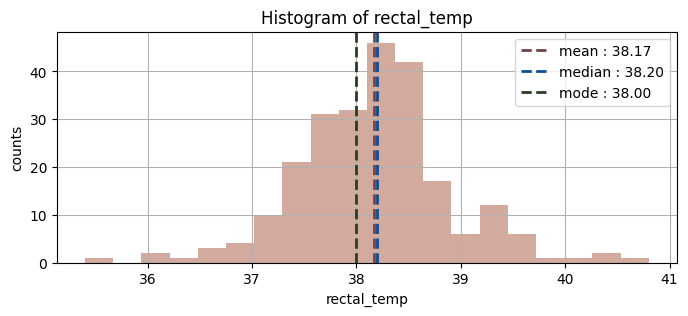

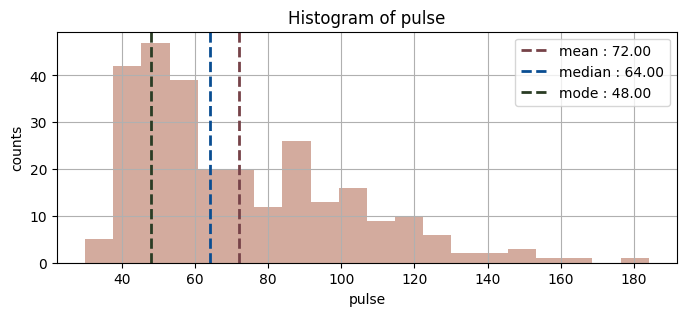

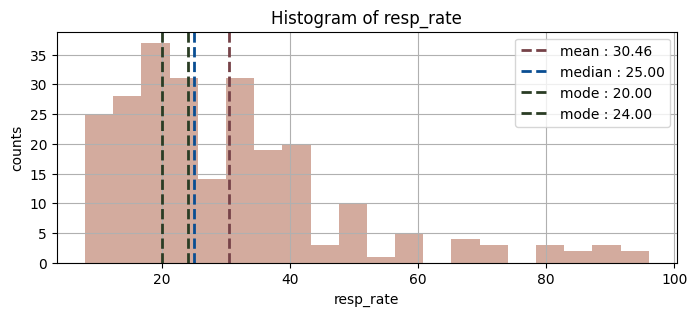

In [424]:
import matplotlib.pyplot as plt

for col in numeric_features:
    fig = plt.figure(figsize=(8,3))
    ax = fig.gca()
    feature = data[col].astype(float)
    feature.hist(bins=20,ax = ax,color=colors[0])
    # data.astype(float).boxplot(by = col, ax = ax)
    mean_feature = ax.axvline(feature.astype(float).mean(), color = colors[1],linestyle = 'dashed', linewidth=2, label='mean : {:0.2f}'.format(feature.astype(float).mean()))
    median_feature = ax.axvline(feature.astype(float).median(), color = colors[3],linestyle = 'dashed', linewidth=2, label='median : {:0.2f}'.format(feature.astype(float).median()))
    for mode in feature.astype(float).mode():
        mode_feature = ax.axvline(mode, linestyle = 'dashed', color=colors[4], linewidth=2, label='mode : {:0.2f}'.format(mode))
    ax.set_title('Histogram of ' + col)
    ax.set_ylabel('counts')
    ax.set_xlabel(col)
    plt.legend()
    plt.show()

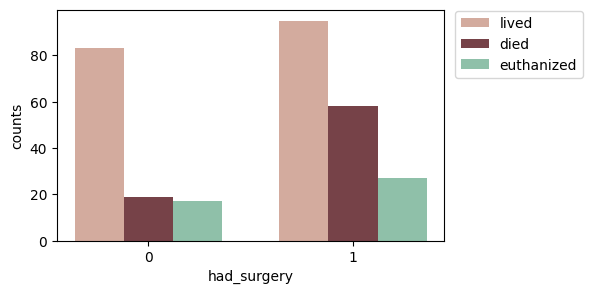

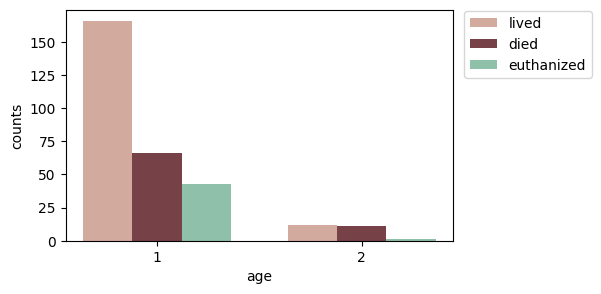

In [425]:
outcomes = data['outcome_in_words'].unique()
for oc in outcomes:
        oc_dx = list(np.where(data['outcome_in_words'] == oc)[0])
        if oc == 'lived':
                lived_data = data.iloc[oc_dx]
        elif oc == 'died':
                died_data = data.iloc[oc_dx]
        elif oc == 'euthanized':
                euth_data = data.iloc[oc_dx]

for col in categorical_features:
    # graphing.histogram(data, label_x=col, label_colour='outcome_in_words', show=True)
    # fig = plt.figure(figsize=(8,3))
    # ax = fig.gca()
    # feature = data[col].astype(float)
    # feature.hist(ax = ax,grid=False)
    # ax.set_title('Histogram of ' + col)
    # ax.set_ylabel('counts')
    # ax.set_xlabel(col)
    # plt.show()

    fig, ax = plt.subplots(figsize=(5,3))
    n_bars = data[col].nunique()
#     ax_bars = np.linspace(0,n_bars-1,n_bars).astype(int)
    ax_bars = data[col].unique().astype(float)
    ax = fig.gca()
    plot_feature = [lived_data[col].astype(float),died_data[col].astype(float),euth_data[col].astype(float)]
    plt.hist(plot_feature, color=[colors[0],colors[1],colors[2]], 
             bins=[x for i in ax_bars for x in (i-0.45,i+0.45)],
             label=[outcomes[2],outcomes[0],outcomes[1]])
    ax.set_xlabel(col)
    ax.set_ylabel('counts')
    ax.set_xticks(ax_bars)
    plt.legend(bbox_to_anchor=(1.375, 1.025))
    plt.show()

    

In [426]:
# It may provide more insight to create a binary category for the outcome

def binary_outcome(y):
    outcomes = []
    for val in y:
        if val == 'lived':
            outcome = 1
        else:
            outcome = 0
        outcomes += [outcome]
    return outcomes

# Add new column with outcome in words
data.insert(0, 'binary_outcome', binary_outcome(data['outcome_in_words']),True)
test_data.insert(0, 'binary_outcome', binary_outcome(test_data['outcome_in_words']),True)
data.head()

,binary_outcome,outcome_in_words,had_surgery,age,hospital_number,rectal_temp,pulse,resp_rate,temp_of_extremities,peripheral_pulse,...,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,had_surgical_lesion,lesion_site,lesion_type,lesion_subtype,lesion_specific_code
0,0,died,0,1,530101,38.5,66.0,28.0,3,3,...,45.0,8.4,NaN,NaN,2,2,11300,0,0,2
1,0,euthanized,1,1,534817,39.2,88.0,20.0,NaN,NaN,...,50.0,85.0,2,2.0,3,2,2208,0,0,2
2,1,lived,0,1,530334,38.3,40.0,24.0,1,1,...,33.0,6.7,NaN,NaN,1,2,0,0,0,1
3,0,died,1,2,5290409,39.1,164.0,84.0,4,1,...,48.0,7.2,3,5.3,2,1,2208,0,0,1
4,0,died,0,1,530255,37.3,104.0,35.0,NaN,NaN,...,74.0,7.4,NaN,NaN,2,2,4300,0,0,2


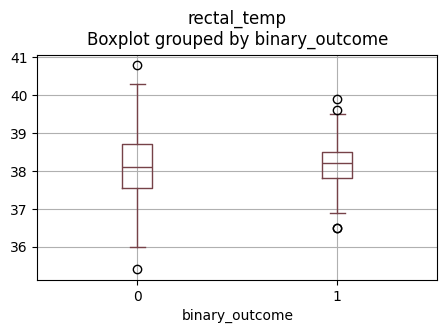

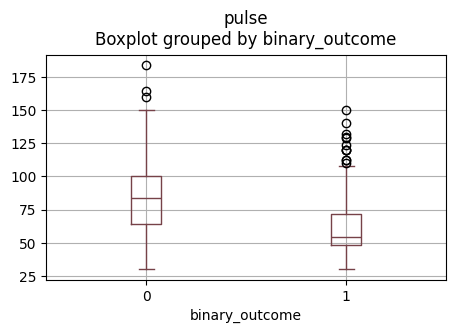

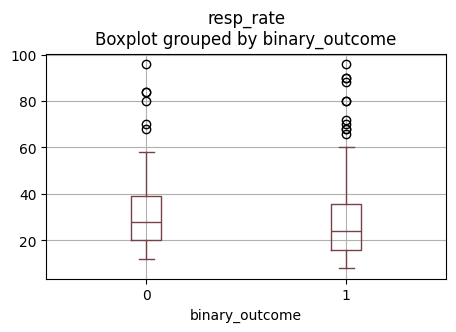

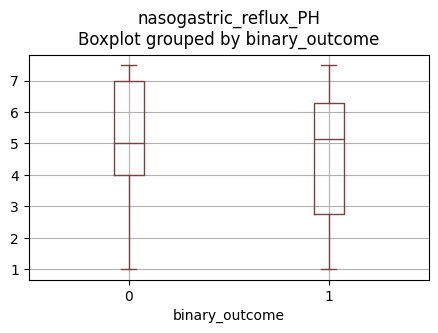

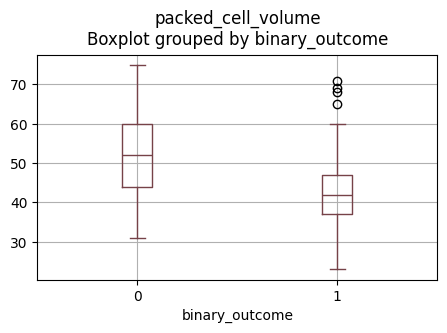

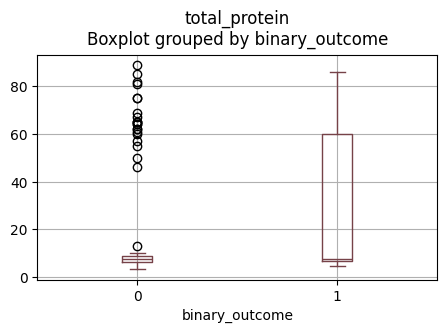

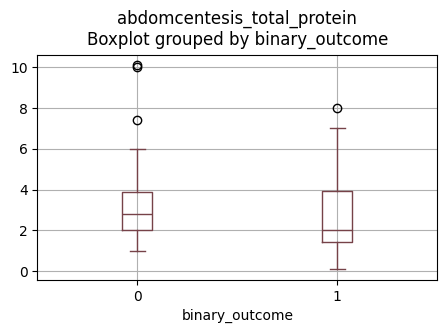

In [427]:
# Specify label column
label = 'binary_outcome'

# Plot numeric features as box and whisker plots
for col in all_numeric_features:
    data.boxplot(column=col, by=label,figsize=(5,3),color=colors[1])
    plt.title(col,y=1.1)
plt.show()

Training cases: 299
Test cases: 67
HistGradientBoostingClassifier()
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      1.00       178

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



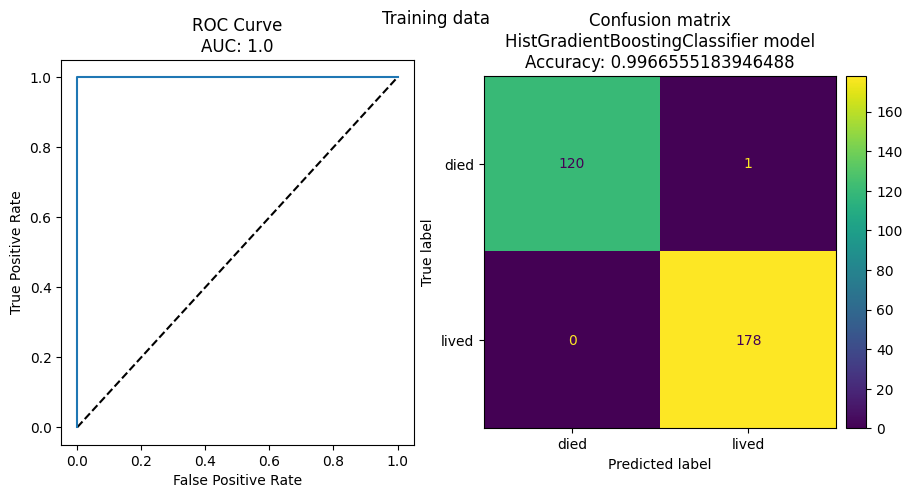

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.88      0.77      0.82        47

    accuracy                           0.76        67
   macro avg       0.73      0.76      0.74        67
weighted avg       0.79      0.76      0.77        67



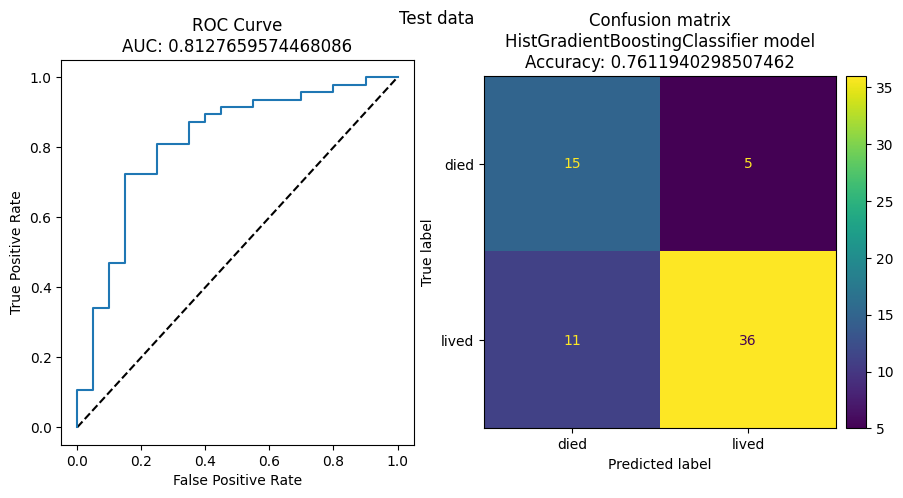

In [428]:
# Train the model
from sklearn.ensemble import HistGradientBoostingClassifier

# Combine features to be used in the model
numeric_features = ['rectal_temp','pulse','resp_rate','nasogastric_reflux_PH',
                   'packed_cell_volume','total_protein','abdomcentesis_total_protein']

categorical_features = ['had_surgery','age','temp_of_extremities',
                        'peripheral_pulse','mucous_membrane','capillary_refill_time',
                        'pain','peristalsis','abdominal_distension','nasogastric_tube',
                        'nasogastric_reflux','rectal_examination_feces','abdomen',
                        'had_surgical_lesion']
features = categorical_features + numeric_features

X_train, y_train = data[features], data[label]
X_test, y_test = test_data[features], test_data[label]
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

# Train
first_model = HistGradientBoostingClassifier().fit(X_train, y_train)
print(first_model)

def cm_roc_auc_plot(X,y,model,ttl='',do_show_plot = True):
    import sklearn
    from sklearn.metrics import accuracy_score, classification_report 
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    predictions = model.predict(X)
    cm = confusion_matrix(y,predictions)
    y_scores = model.predict_proba(X)

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_scores[:,1])
    auc = roc_auc_score(y,y_scores[:,1])
    accuracy = accuracy_score(y, predictions)

    if do_show_plot:    
        print(classification_report(y, predictions))

        fig, ax = plt.subplots(1,2,figsize=(10, 5))

        # plot ROC curve
        # Plot the diagonal 50% line
        ax[0].plot([0, 1], [0, 1], 'k--')
        # Plot the FPR and TPR achieved by our model
        ax[0].plot(fpr, tpr)
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve\nAUC: ' + str(auc))

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['died','lived'])
        disp.plot(ax=ax[1], colorbar=False)
        disp.ax_.set_title('Confusion matrix\nHistGradientBoostingClassifier model\nAccuracy: '
                + str(accuracy))
        # Adding custom colorbar
        cax = fig.add_axes([ax[1].get_position().x1+0.01,ax[1].get_position().y0,0.02,ax[1].get_position().height])
        plt.colorbar(disp.im_,  cax=cax)
        plt.suptitle(ttl)
        plt.show()

    return accuracy, auc

cm_roc_auc_plot(X_train,y_train,first_model,'Training data')
cm_roc_auc_plot(X_test,y_test,first_model,'Test data');


This isn't half bad for a first model. However, it's clearly overtrained.

Now I'll try to improve the performance of the model by tuning the hyperparameters of the model. 

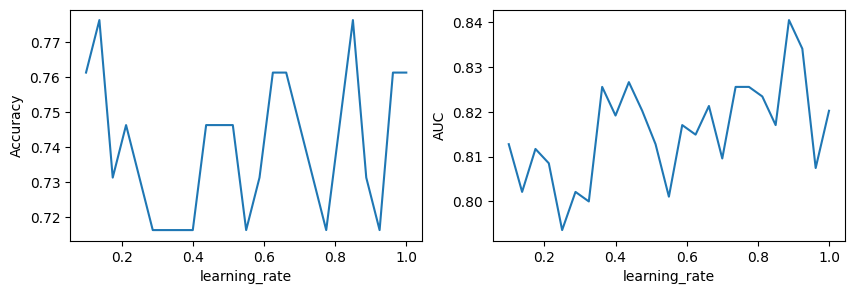

In [429]:
# Tune some of the hyperparameters to see if we can improve the performance of the model on the test data.
learning_rates = np.linspace(0.1,1,25)
accuracies = []
aucs = []
for lr in learning_rates:
    model = HistGradientBoostingClassifier(learning_rate=lr).fit(X_train, y_train)
    accuracy_lr, auc_lr = cm_roc_auc_plot(X_test,y_test,model,'Test data, learning_rate = ' + str(lr),do_show_plot=False)
    accuracies = accuracies + [accuracy_lr]
    aucs = aucs + [auc_lr]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(learning_rates,accuracies)
ax[0].set_xlabel('learning_rate')
ax[0].set_ylabel('Accuracy')
ax[1].plot(learning_rates,aucs)
ax[1].set_xlabel('learning_rate')
ax[1].set_ylabel('AUC')
plt.show()

best_learning_rate = 0.9

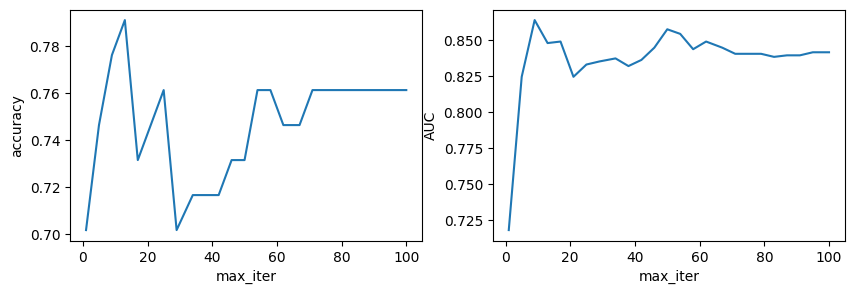

In [430]:
max_iters = np.linspace(1,100,25).astype(int)
accuracies = []
aucs = []
for mi in max_iters:
    model = HistGradientBoostingClassifier(learning_rate=best_learning_rate, max_iter=mi).fit(X_train, y_train)
    accuracy_mi, auc_mi = cm_roc_auc_plot(X_test,y_test,model,'Test data, max_iter = ' + str(mi),do_show_plot=False)
    accuracies = accuracies + [accuracy_mi]
    aucs = aucs + [auc_mi]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(max_iters,accuracies)
ax[0].set_xlabel('max_iter')
ax[0].set_ylabel('accuracy')
ax[1].plot(max_iters,aucs)
ax[1].set_xlabel('max_iter')
ax[1].set_ylabel('AUC')
plt.show()

best_max_iter = 50

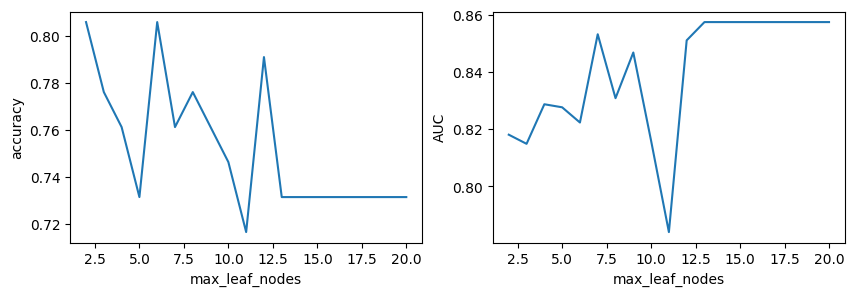

In [431]:
max_leaf_nodess = np.linspace(2,20,25).astype(int)
accuracies = []
aucs = []
for mln in max_leaf_nodess:
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=mln).fit(X_train, y_train)
    accuracy_mln, auc_mln = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_mln]
    aucs = aucs + [auc_mln]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(max_leaf_nodess,accuracies)
ax[0].set_xlabel('max_leaf_nodes')
ax[0].set_ylabel('accuracy')
ax[1].plot(max_leaf_nodess,aucs)
ax[1].set_xlabel('max_leaf_nodes')
ax[1].set_ylabel('AUC')
plt.show()

best_max_leaf_nodes = 13

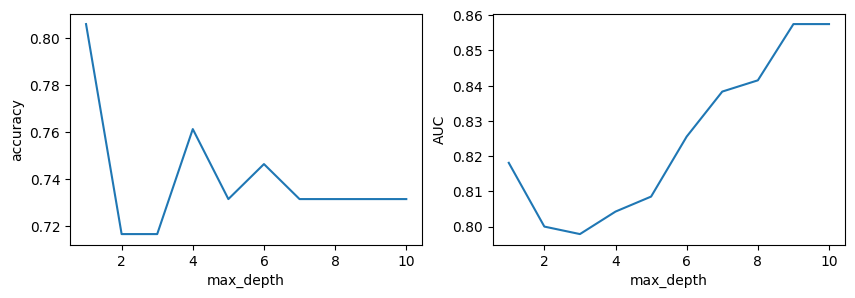

In [432]:
max_depths = np.linspace(1,10,10).astype(int)
accuracies = []
aucs = []
for md in max_depths:
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes,max_depth=md).fit(X_train, y_train)
    accuracy_md, auc_md = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_md]
    aucs = aucs + [auc_md]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(max_depths,accuracies)
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('accuracy')
ax[1].plot(max_depths,aucs)
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('AUC')
plt.show()

best_max_depth = 10

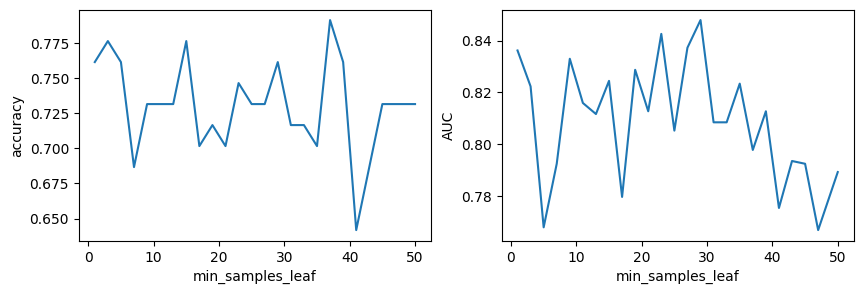

In [433]:
min_samples = np.linspace(1,50,25).astype(int)
accuracies = []
aucs = []
for ms in min_samples:
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes,max_depth=best_max_depth,
        min_samples_leaf=ms).fit(X_train, y_train)
    accuracy_ms, auc_ms = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_ms]
    aucs = aucs + [auc_ms]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(min_samples,accuracies)
ax[0].set_xlabel('min_samples_leaf')
ax[0].set_ylabel('accuracy')
ax[1].plot(min_samples,aucs)
ax[1].set_xlabel('min_samples_leaf')
ax[1].set_ylabel('AUC')
plt.show()

best_min_samples = 25

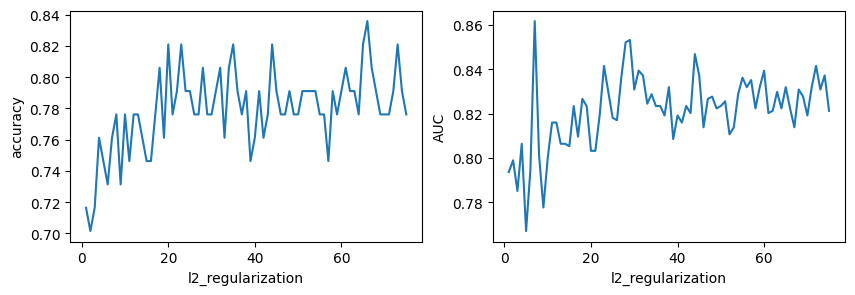

In [434]:
l2_regularizations = np.linspace(1,75,75)
accuracies = []
aucs = []
for l2 in l2_regularizations:
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes, max_depth=best_max_depth,
        min_samples_leaf=best_min_samples, l2_regularization=l2
        ).fit(X_train, y_train)
    accuracy_l2, auc_l2 = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_l2]
    aucs = aucs + [auc_l2]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(l2_regularizations,accuracies)
ax[0].set_xlabel('l2_regularization')
ax[0].set_ylabel('accuracy')
ax[1].plot(l2_regularizations,aucs)
ax[1].set_xlabel('l2_regularization')
ax[1].set_ylabel('AUC')
plt.show()

best_l2_regularization = 30

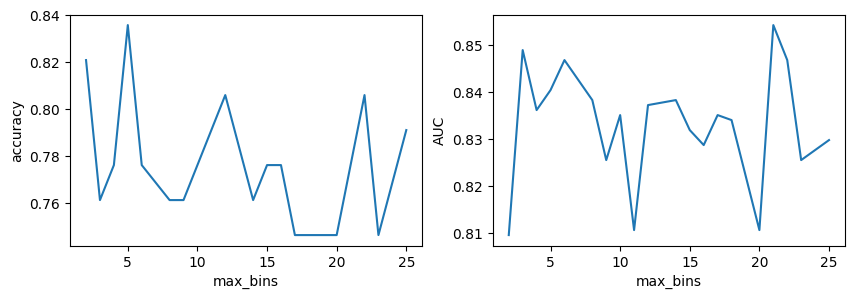

In [435]:
max_binss = np.linspace(2,25,20).astype(int)
accuracies = []
aucs = []
for mb in max_binss:
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes, max_depth=best_max_depth,
        min_samples_leaf=best_min_samples, l2_regularization=best_l2_regularization,
        max_bins=mb).fit(X_train, y_train)
    accuracy_mb, auc_mb = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_mb]
    aucs = aucs + [auc_mb]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(max_binss,accuracies)
ax[0].set_xlabel('max_bins')
ax[0].set_ylabel('accuracy')
ax[1].plot(max_binss,aucs)
ax[1].set_xlabel('max_bins')
ax[1].set_ylabel('AUC')
plt.show()

best_max_bins = 12

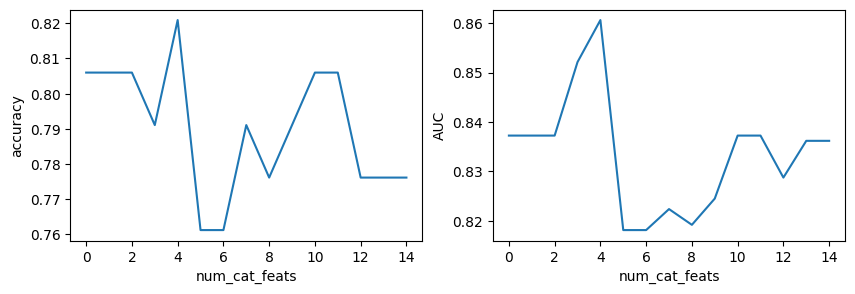

In [436]:
num_cat_feats = np.linspace(0,len(categorical_features),len(categorical_features)+1).astype(int)
accuracies = []
aucs = []
for cf in num_cat_feats:
    if cf == 0:
        cat_featss = []
    else:
        cat_featss = np.linspace(0,cf-1,cf).astype(int)
    model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes, max_depth=best_max_depth,
        min_samples_leaf=best_min_samples, l2_regularization=best_l2_regularization,
        max_bins=best_max_bins,categorical_features=cat_featss).fit(X_train, y_train)
    accuracy_cf, auc_cf = cm_roc_auc_plot(X_test,y_test,model,do_show_plot=False)
    accuracies = accuracies + [accuracy_cf]
    aucs = aucs + [auc_cf]

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(num_cat_feats,accuracies)
ax[0].set_xlabel('num_cat_feats')
ax[0].set_ylabel('accuracy')
ax[1].plot(num_cat_feats,aucs)
ax[1].set_xlabel('num_cat_feats')
ax[1].set_ylabel('AUC')
plt.show()

best_cat_feats = []

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       121
           1       0.99      1.00      1.00       178

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



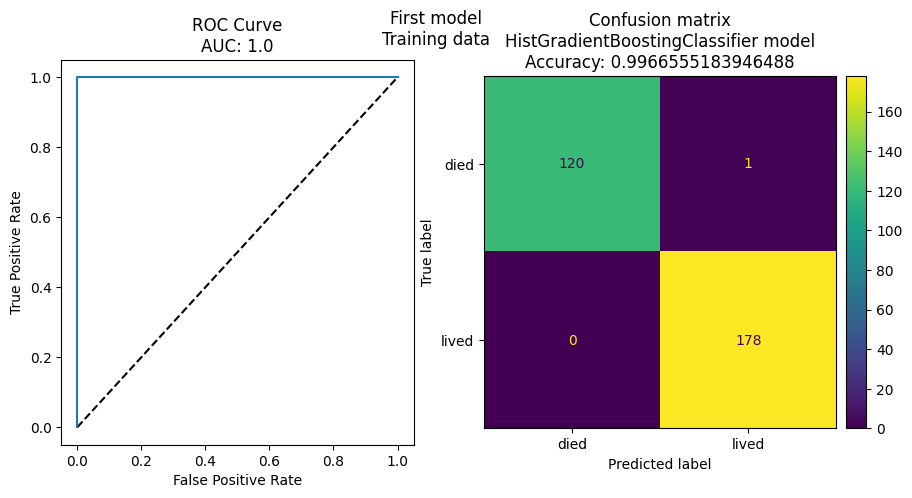

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       121
           1       0.96      0.98      0.97       178

    accuracy                           0.96       299
   macro avg       0.97      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299



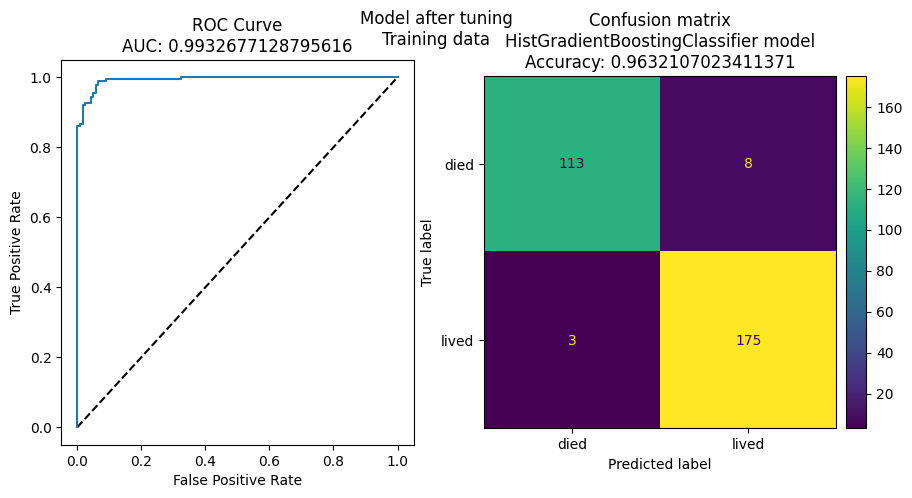

              precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.88      0.77      0.82        47

    accuracy                           0.76        67
   macro avg       0.73      0.76      0.74        67
weighted avg       0.79      0.76      0.77        67



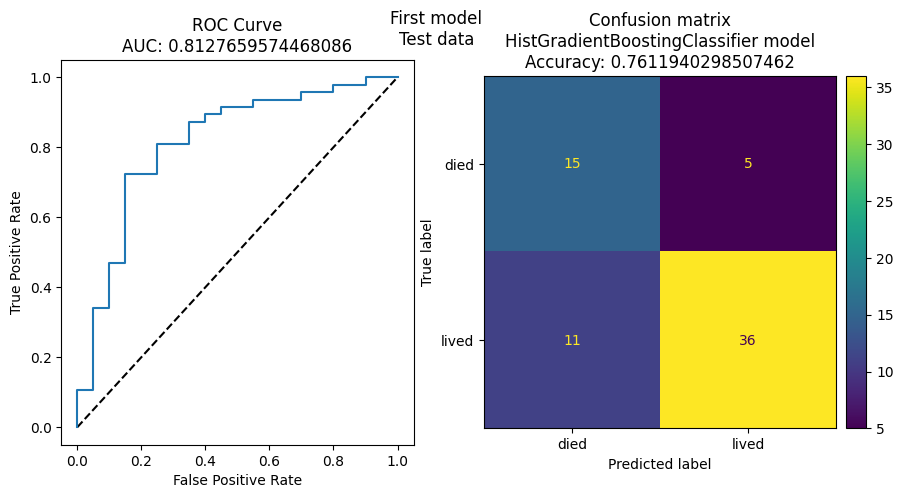

              precision    recall  f1-score   support

           0       0.64      0.80      0.71        20
           1       0.90      0.81      0.85        47

    accuracy                           0.81        67
   macro avg       0.77      0.80      0.78        67
weighted avg       0.83      0.81      0.81        67



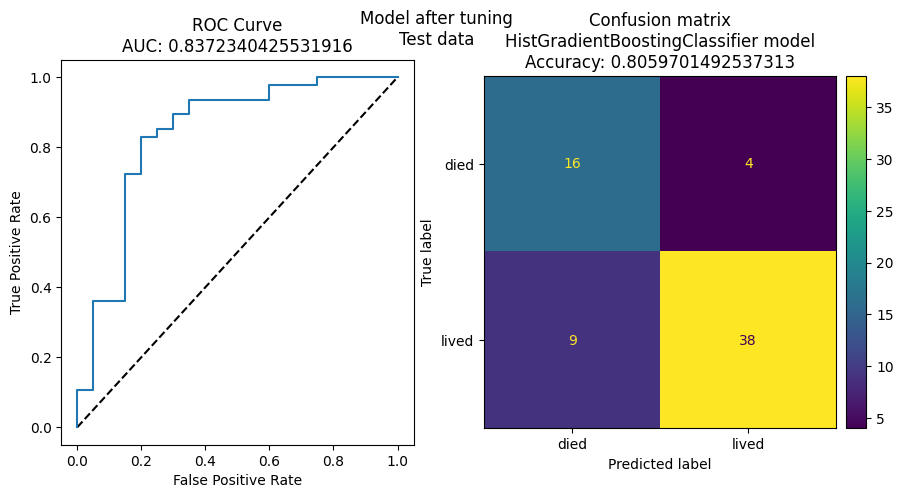

In [437]:
final_HGBC_model = HistGradientBoostingClassifier(
        learning_rate=best_learning_rate, max_iter=best_max_iter,
        max_leaf_nodes=best_max_leaf_nodes, max_depth=best_max_depth,
        min_samples_leaf=best_min_samples, l2_regularization=best_l2_regularization,
        max_bins=best_max_bins,categorical_features=best_cat_feats)
fitted_HGBC_model = final_HGBC_model.fit(X_train, y_train)
accuracy, auc = cm_roc_auc_plot(X_train,y_train,first_model,'First model\nTraining data',do_show_plot=True)
accuracy, auc = cm_roc_auc_plot(X_train,y_train,fitted_HGBC_model,'Model after tuning\nTraining data',do_show_plot=True)

accuracy, auc = cm_roc_auc_plot(X_test,y_test,first_model,'First model\nTest data',do_show_plot=True)
accuracy, auc = cm_roc_auc_plot(X_test,y_test,fitted_HGBC_model,'Model after tuning\nTest data',do_show_plot=True)